# COVID-19 Prediction

This is the prediction task for COVID-19 confirmed cases in USA, a sub-project of COVID tracking project.

## Import Libraries

In [1]:
import requests
import json
from datetime import datetime, timedelta
import datetime
import pyodbc
from tqdm import tqdm 

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

from sklearn.metrics import mean_squared_error

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Config

1. Database Config

In [ ]:
##Database SERVER Config
server = 'name.database.windows.net'
database = 'name'
username = 'name'
password = 'password'
#####################
##Connect driver
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + server + ';DATABASE=' + database + ';UID=' + username + ';PWD=' + password)
cursor = conn.cursor()

2. API config

In [ ]:
url = "https://api.covid19api.com/total/dayone/country/United States of America"

3. LSTM Config

Define the window size of 14, which means we only forecast next 14 days. 

In [4]:
# Epochs
epochs = 500
# Define a test size
test_size = 14
# Define a window size
window_size = 14
# Define a future size
future = 14
# Define target column
target = 'deaths'

MODEL_PATH = 'model.bin'

## Extract data to database

In [5]:
# insert into covid table
payload = {}
headers = {}
response = requests.request("GET", url, headers=headers, data=payload)
data = response.text.encode('utf8')
data = json.loads(data)

tsql = r"""
INSERT INTO dbo.covid (postdate,deaths,comfirmed)
VALUES (?,?,?)
"""

times = 0
for row1, row2 in zip(data[:-1],data[1:]):
    x = row2['Date'] 
    postdate = datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%d')
#     print(postdate)
    deaths = row2['Deaths'] - row1['Deaths']
#     print(deaths)
    comfirmed = row2['Confirmed'] - row1['Confirmed']
#     print(comfirmed)
    with cursor.execute(tsql,postdate,deaths,comfirmed):
        times +=1
        print(times)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


## Load data from database

In [6]:
## read table
def read_covid():
    postdate = []
    deaths = []
    confirmed = []
    tsql = "SELECT [postdate],[deaths],[comfirmed] FROM [dbo].[covid] ORDER by postdate ASC"
    with cursor.execute(tsql):
        rows = cursor.fetchall()
    for row in rows:
        postdate.append(row[0])
        deaths.append(row[1])
        confirmed.append(row[2])
        df = pd.DataFrame(list(zip(postdate, deaths, confirmed)), columns = ['postdate', 'deaths', 'confirmed'])
        
    return df


In [7]:
data = read_covid()
data.head()

,postdate,deaths,confirmed
0,2020-01-23,0,0
1,2020-01-24,0,1
2,2020-01-25,0,0
3,2020-01-26,0,3
4,2020-01-27,0,0


In [8]:
data.tail()

,postdate,deaths,confirmed
195,2020-08-05,1372,52810
196,2020-08-06,1250,59692
197,2020-08-07,1243,58173
198,2020-08-08,1076,56174
199,2020-08-09,515,46935


In [9]:
df = data[60:]

## Plotting time series data


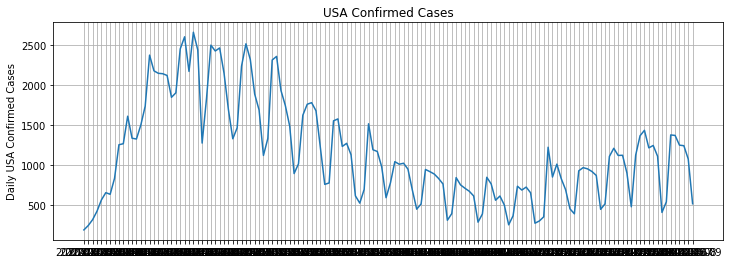

In [10]:
plt.figure(figsize=(12,4))
plt.title('USA Confirmed Cases')
plt.ylabel('Daily USA Confirmed Cases')
plt.grid(True)
# plt.autoscale(axis='x',tight=True)
plt.plot(df['postdate'], df[target])
plt.show()

As shown in this chart, the confirmed cases are droping but also fluctuating. There are several interesting take outs:
1. Each week is somehow a period, cases reach the peak around Thuesday, start droping on weekends and reach the lowest point around Monday. 
    
    This is called "weekend effect". The reasons given include less testing and reporting of performed tests on weekends, and fewer deaths compiled by the responsible agencies. The Dutch counterpart to the U.S. Centers for Disease Control and Prevention (CDC) the RIVM, for example, admits that there’s a weekend effect, which results in incomplete data and a delay in reporting of numbers of cases and deaths. So, often early in the week, you’ll see relatively high numbers of reported tests and deaths as officials process the backlog.
    
2. The overall trend is promising, but also shows a little bit rebound.

Though the data could not be accurate due to many issues, such as lack of testing, late report, human intervene and so on. We could find there are certern patterns that could give us some useful information, so that build a model to predict the trend.

## Data Preprocessing

Because it is time-series data, we could not use the previous data to predict the later one. The test data will be the last 14 days data.

In [11]:
# Extract values from the source .csv file
y = df[target].values.astype(float)


# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [12]:
y

array([ 187.,  242.,  316.,  422.,  563.,  654.,  634.,  834., 1255.,
       1268., 1613., 1337., 1327., 1502., 1739., 2379., 2182., 2151.,
       2146., 2124., 1850., 1906., 2457., 2609., 2175., 2666., 2445.,
       1276., 1834., 2504., 2431., 2469., 2154., 1697., 1330., 1467.,
       2241., 2521., 2324., 1891., 1692., 1121., 1333., 2318., 2363.,
       1936., 1747., 1488.,  894., 1015., 1626., 1763., 1783., 1681.,
       1216.,  758.,  776., 1555., 1579., 1234., 1273., 1130.,  614.,
        523.,  695., 1518., 1192., 1171.,  979.,  591.,  777., 1043.,
       1011., 1023.,  949.,  687.,  447.,  513.,  945.,  918.,  888.,
        832.,  763.,  308.,  391.,  843.,  752.,  710.,  672.,  613.,
        284.,  387.,  847.,  764.,  559.,  612.,  500.,  251.,  364.,
        735.,  687.,  724.,  653.,  271.,  299.,  351., 1224.,  850.,
       1012.,  830.,  691.,  451.,  389.,  928.,  968.,  953.,  920.,
        870.,  445.,  514., 1109., 1211., 1121., 1123.,  901.,  477.,
       1125., 1368.,

In [13]:
test_set

array([1125., 1368., 1436., 1216., 1246., 1111.,  406.,  539., 1378.,
       1372., 1250., 1243., 1076.,  515.])

## Normalize data


In [14]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [15]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
test_norm = scaler.transform(test_set.reshape(-1,1))


In [16]:
train_norm.min()

-1.0

In [17]:
train_norm.max()

1.0

In [18]:
train_norm.mean()

-0.2093330003777765

In [19]:
type(train_norm)

numpy.ndarray

In [20]:
# train_norm = torch.FloatTensor(train_norm).view(-1)
# test_norm = torch.FloatTensor(test_norm).view(-1)

## Dataloader for LSTM

In [21]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

112

In [22]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-1.0000, -0.9556, -0.8959, -0.8104, -0.6967, -0.6232, -0.6394, -0.4780,
         -0.1384, -0.1279,  0.1505, -0.0722, -0.0803,  0.0609]),
 tensor([0.2521]))

In [23]:
# Display the last seq/label tuple in the train data
train_data[-1]

(tensor([-0.7870, -0.8370, -0.4022, -0.3699, -0.3820, -0.4086, -0.4490, -0.7919,
         -0.7362, -0.2562, -0.1739, -0.2465, -0.2449, -0.4240]),
 tensor([-0.7660]))

In [24]:
test_data = input_data(test_norm,1)

## Build the Model

A LSTM pytorch model.

In [25]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 100, output_size =1):
        super(LSTMnetwork, self).__init__()
        self.hidden_size = hidden_size
        
        #add LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        #add a fully-connected layer
        self.linear = nn.Linear(hidden_size, output_size)
            
        # Initialize h0 and c0
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))
            
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

## Instantiate the model, define loss and optimization functions

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')
    
model = LSTMnetwork()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(device)
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [27]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Train the model

In [28]:
def train_fn(data, model, optimizer, device):
    model.train()

#     try:
#         with tqdm(data, total=len(data)) as tk0:
    for bi, (seq, y_train) in enumerate(data):
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
               torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = loss_fn(y_pred, y_train)

        loss.backward()
        optimizer.step()
    return loss
        

## Evaluate the model

In [29]:


def eval_fn(data_norm, model, device):
    model.eval()
    # Add the last window of training values to the list of predictions
    preds = data_norm[-window_size:].tolist()
    for i in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())

    return preds

## Run predictions and compare to known test set

The early stopping strategy is that if validation loss doesn't improve for 30 iterations, the training process will stop.

In [30]:
import time
start_time = time.time()

best_loss = np.inf

early_stop = 0 

train_losses = []
vali_losses = []

for epoch in range(epochs):
    early_stop += 1
    if early_stop == 30:
        break
    train_loss = train_fn(train_data, model, optimizer, device)
    train_losses.append(train_loss)
    preds = eval_fn(train_norm, model, device)
    
    predictions = torch.tensor(preds[window_size:])
    real = torch.tensor(test_norm.reshape(1,-1).tolist()[0])
#     valid_loss = mean_squared_error(preds[window_size:], test_norm.reshape(1,-1).tolist()[0])
    valid_loss = loss_fn(predictions,real)
    vali_losses.append(valid_loss)
    print(f"Epoch: {epoch+1}, train_loss: {train_loss.item():10.8f}, valid_loss: {valid_loss.item():10.8f}, best valid loss: {best_loss:10.8f}")
    if valid_loss < best_loss:
        early_stop = 0
        best_loss = valid_loss
        torch.save(model.state_dict(), MODEL_PATH)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')




Epoch: 1, train_loss: 0.15589438, valid_loss: 0.08686217, best valid loss:        inf
Epoch: 2, train_loss: 0.18398227, valid_loss: 0.08212634, best valid loss: 0.08686217
Epoch: 3, train_loss: 0.17913461, valid_loss: 0.08520812, best valid loss: 0.08212634
Epoch: 4, train_loss: 0.17197804, valid_loss: 0.08940565, best valid loss: 0.08212634
Epoch: 5, train_loss: 0.16330040, valid_loss: 0.09495842, best valid loss: 0.08212634
Epoch: 6, train_loss: 0.15571798, valid_loss: 0.10047926, best valid loss: 0.08212634
Epoch: 7, train_loss: 0.14869732, valid_loss: 0.10476621, best valid loss: 0.08212634
Epoch: 8, train_loss: 0.13961802, valid_loss: 0.10627753, best valid loss: 0.08212634
Epoch: 9, train_loss: 0.07047405, valid_loss: 0.02979119, best valid loss: 0.08212634
Epoch: 10, train_loss: 0.05372583, valid_loss: 0.04974413, best valid loss: 0.02979119
Epoch: 11, train_loss: 0.03889640, valid_loss: 0.04609399, best valid loss: 0.02979119
Epoch: 12, train_loss: 0.06855434, valid_loss: 0.044

## Plot the losses

As we can see, the training loss and validation loss find a relatively low point around 9th iteration.

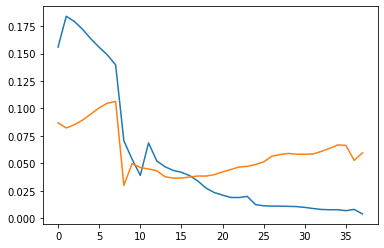

In [31]:
plt.plot(train_losses)
plt.plot(vali_losses)

## Plot the data

In [32]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[ 513.71652728],
       [1067.53520386],
       [1124.08960924],
       [1032.51917017],
       [ 979.79429543],
       [ 814.17257154],
       [ 530.16774675],
       [ 526.52908498],
       [ 959.71335366],
       [1050.19110817],
       [ 991.85782118],
       [ 951.12916756],
       [ 795.25723386],
       [ 531.50593442]])

In [33]:
df[target][-window_size:]

186    1125
187    1368
188    1436
189    1216
190    1246
191    1111
192     406
193     539
194    1378
195    1372
196    1250
197    1243
198    1076
199     515
Name: deaths, dtype: int64

In [34]:
x = df['postdate'][-future:]

In [35]:
type(x)

pandas.core.series.Series

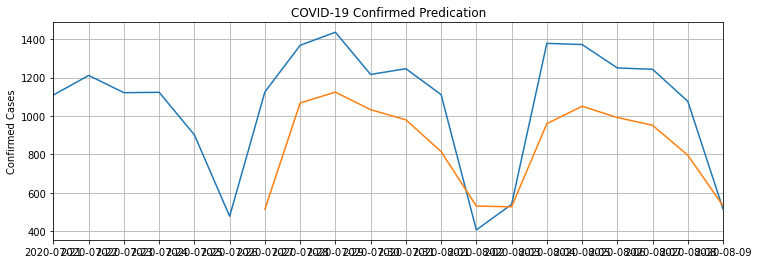

In [36]:
plt.figure(figsize=(12,4))
plt.title('COVID-19 Confirmed Predication')
plt.ylabel('Confirmed Cases')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['postdate'][-20:], df[target][-20:])
plt.plot(x,true_predictions)
plt.show()

## Forecast into an unknown future

In [37]:
L = len(y)

y_norm = scaler.transform(y.reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)
preds = y_norm[-window_size:].tolist()


In [38]:
preds

[-0.2432432472705841,
 -0.04719645157456398,
 0.007664380595088005,
 -0.16982653737068176,
 -0.14562323689460754,
 -0.2545381188392639,
 -0.8233158588409424,
 -0.7160145044326782,
 -0.039128679782152176,
 -0.04396934062242508,
 -0.14239612221717834,
 -0.14804357290267944,
 -0.28277531266212463,
 -0.7353771924972534]

In [39]:

model = LSTMnetwork()
model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(MODEL_PATH, map_location=device).items()}) 
model.to(device)
model.eval()

for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))


In [40]:
true_predictions

array([[1124.99999501],
       [1367.99999827],
       [1435.99999975],
       [1216.00000693],
       [1245.99999787],
       [1111.0000017 ],
       [ 405.99999297],
       [ 539.00002176],
       [1378.00000141],
       [1372.0000023 ],
       [1250.00000651],
       [1242.99999139],
       [1075.99999996],
       [ 514.9999699 ],
       [ 770.17291975],
       [1171.44285698],
       [1501.75764755],
       [1529.96108572],
       [1329.88286723],
       [ 995.49685235],
       [ 712.24549231],
       [ 772.65565571],
       [1258.24489892],
       [1602.23771856],
       [1616.42693691],
       [1373.78990126],
       [1004.09411521],
       [ 705.01286614]])

In [41]:
recent = df['postdate'][-1:].item()
recent = datetime.strptime(recent, '%Y-%m-%d')

In [42]:
recent

datetime.datetime(2020, 8, 9, 0, 0)

In [43]:
x_date = []
new_date = recent
for i in range(future):
    new_date = new_date + timedelta(days=1)
    x_date.append(new_date.strftime('%Y-%m-%d'))
x_date = np.array(x_date)

In [44]:
x_date

array(['2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
       '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
       '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
       '2020-08-22', '2020-08-23'], dtype='<U10')

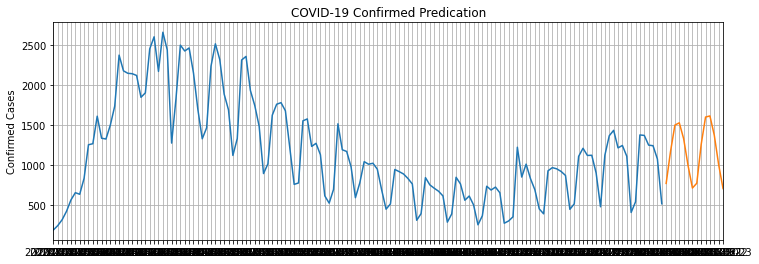

In [45]:
plt.figure(figsize=(12,4))
plt.title('COVID-19 Confirmed Predication')
plt.ylabel('Confirmed Cases')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['postdate'],df[target])
plt.plot(x_date,true_predictions[window_size:])
plt.show()

In [46]:
predictions = true_predictions[window_size:].reshape(1,-1)[0]
predictions

array([ 770.17291975, 1171.44285698, 1501.75764755, 1529.96108572,
       1329.88286723,  995.49685235,  712.24549231,  772.65565571,
       1258.24489892, 1602.23771856, 1616.42693691, 1373.78990126,
       1004.09411521,  705.01286614])

In [47]:
x_date

array(['2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
       '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
       '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
       '2020-08-22', '2020-08-23'], dtype='<U10')

## Update predictions to database

In [48]:
tsql0 = r"""
IF OBJECT_ID('dbo.pre_covid', 'U') IS NOT NULL
DROP TABLE dbo.pre_covid
-- Create the table in the specified schema
CREATE TABLE [dbo].[pre_covid](
    [postdate] [nvarchar](300) NOT NULL,
    [deaths] [int] NOT NULL
) ON [PRIMARY]
"""

tsql = r"""
INSERT INTO dbo.pre_covid (postdate,deaths)
VALUES (?,?)
"""
cursor.execute(tsql0)

times = 0
for date, pred in zip(x_date, predictions): 
    print(str(date))
    print(int(pred))
    with cursor.execute(tsql,date,int(pred)):
        times +=1
        print(times)

2020-08-10
770
1
2020-08-11
1171
2
2020-08-12
1501
3
2020-08-13
1529
4
2020-08-14
1329
5
2020-08-15
995
6
2020-08-16
712
7
2020-08-17
772
8
2020-08-18
1258
9
2020-08-19
1602
10
2020-08-20
1616
11
2020-08-21
1373
12
2020-08-22
1004
13
2020-08-23
705
14


In [49]:
## read table
def read_pre_covid():
    postdate = []
    pre_deaths = []
    tsql = "SELECT [postdate],[deaths] FROM [dbo].[pre_covid] ORDER by postdate ASC"
    with cursor.execute(tsql):
        rows = cursor.fetchall()
    for row in rows:
        postdate.append(row[0])
        pre_deaths.append(row[1])
#         df = pd.DataFrame(list(zip(postdate, deaths, confirmed)), columns = ['postdate', 'deaths', 'confirmed'])
        
    return postdate, pre_deaths


In [50]:
read_pre_covid()

(['2020-08-10',
  '2020-08-11',
  '2020-08-12',
  '2020-08-13',
  '2020-08-14',
  '2020-08-15',
  '2020-08-16',
  '2020-08-17',
  '2020-08-18',
  '2020-08-19',
  '2020-08-20',
  '2020-08-21',
  '2020-08-22',
  '2020-08-23'],
 [770,
  1171,
  1501,
  1529,
  1329,
  995,
  712,
  772,
  1258,
  1602,
  1616,
  1373,
  1004,
  705])